In [1]:
# Setup to analyse an MDP Playground experiment
from mdp_playground.analysis import MDPP_Analysis

# Set the following to True to save PDFs of plots that you generate below
save_fig = False

In [2]:
# Data loading
mdpp_analysis = MDPP_Analysis()

# load multiple experiments data

# experiments = { <exp_name_1>: <dir_name_1>, ... }
# Set dir_name to the location where the CSV files from running an experiment were saved
# Set exp_name to the name that was given to the experiment when running it
experiments = {
             "td3_move_to_a_point_action_max": "/media/suresh/work/ml_hiwi/data/mdpp_12713006",
             "sac_move_to_a_point_action_max": "/media/suresh/work/ml_hiwi/data/mdpp_12746746",
             "td3_move_to_a_point_time_unit": "/media/suresh/work/ml_hiwi/data/mdpp_12713385",
             "sac_move_to_a_point_time_unit": "/media/suresh/work/ml_hiwi/data/mdpp_12747791",
}

list_exp_data = mdpp_analysis.load_data(experiments)

Loading data from a sequential run/already combined runs of experiment configurations.
Training stats read (rows, columns): (1330, 19)
train stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 10, 3)
eval stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 10, 3)
Dimension varied: action_space_max . The values it took: ['0.1', '0.25', '0.5', '1.0', '2.0', '4.0', '8.0'] . Number of values it took: 7 . Index in loaded data: 10
Loading data from a sequential run/already combined runs of experiment configurations.
Training stats read (rows, columns): (1330, 19)
train stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 10, 3)
eval stats shape: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 10, 3)
Dimension varied: action_space_max . The values it took: ['0.1', '0.25', '0.5', '1.0', '2.0', '4.0', '8.0'] . Number of values it took: 7 . Index in loaded data: 10
Loading data from a sequential run/already combined runs of experiment configurations.
Training stats read (rows, columns): (1

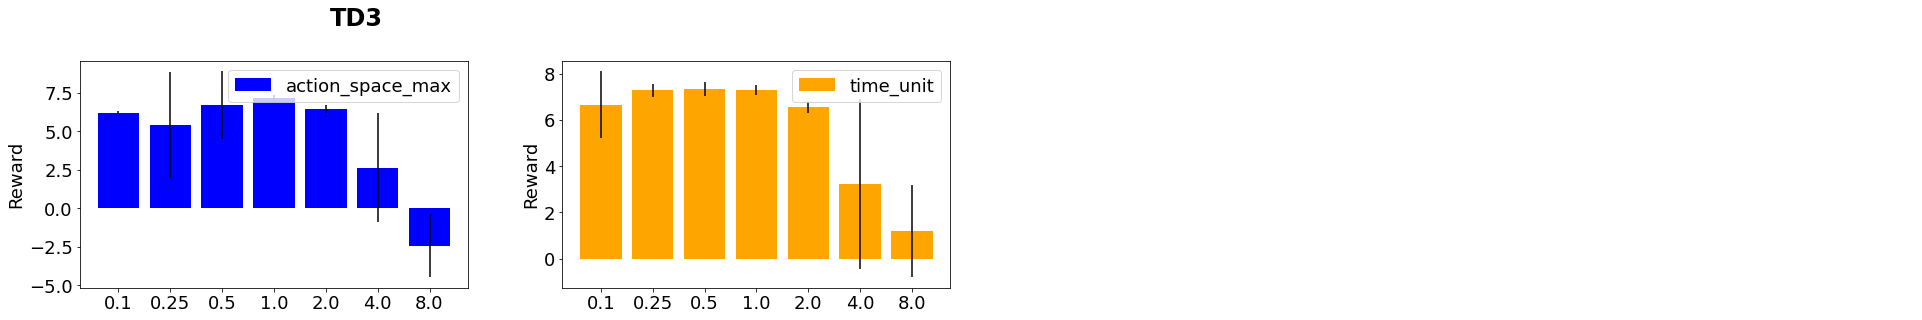

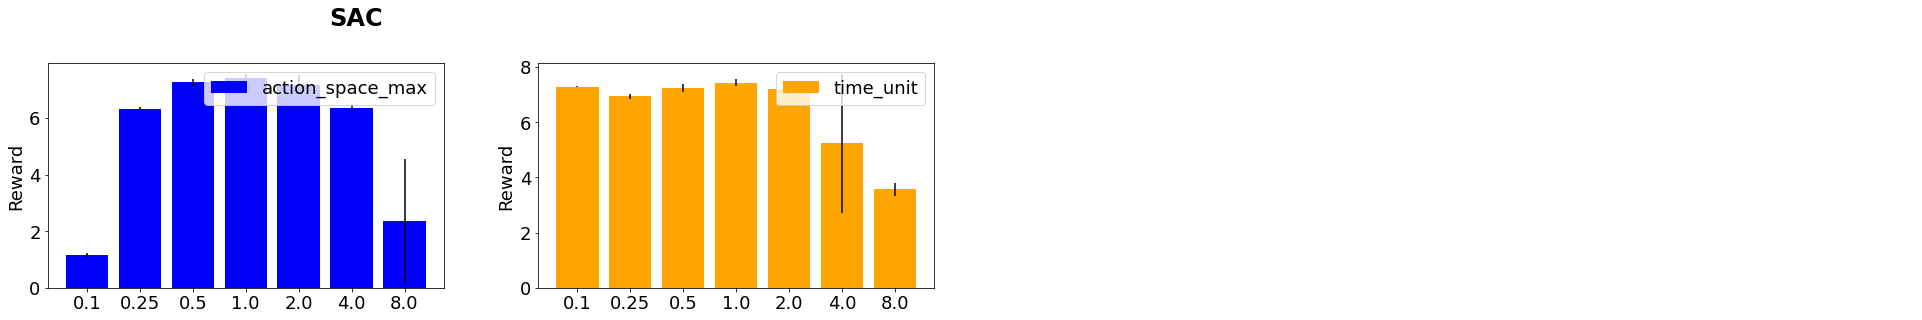

In [3]:
# 1-D: Plots showing reward after 20k timesteps when varying a single meta-feature
# Plots across 10 runs: Training: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, plot_type = "agent")

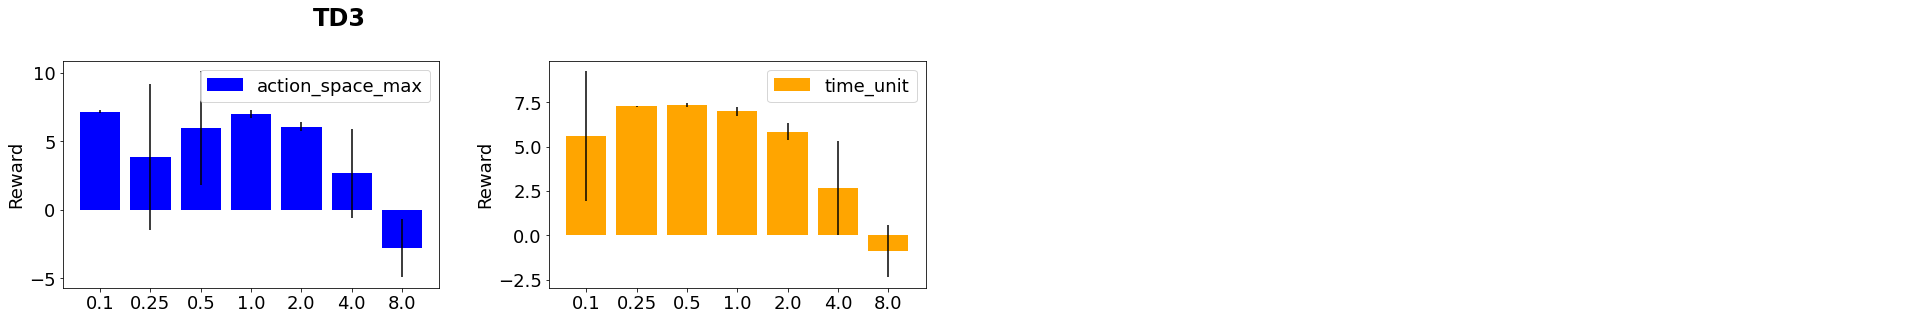

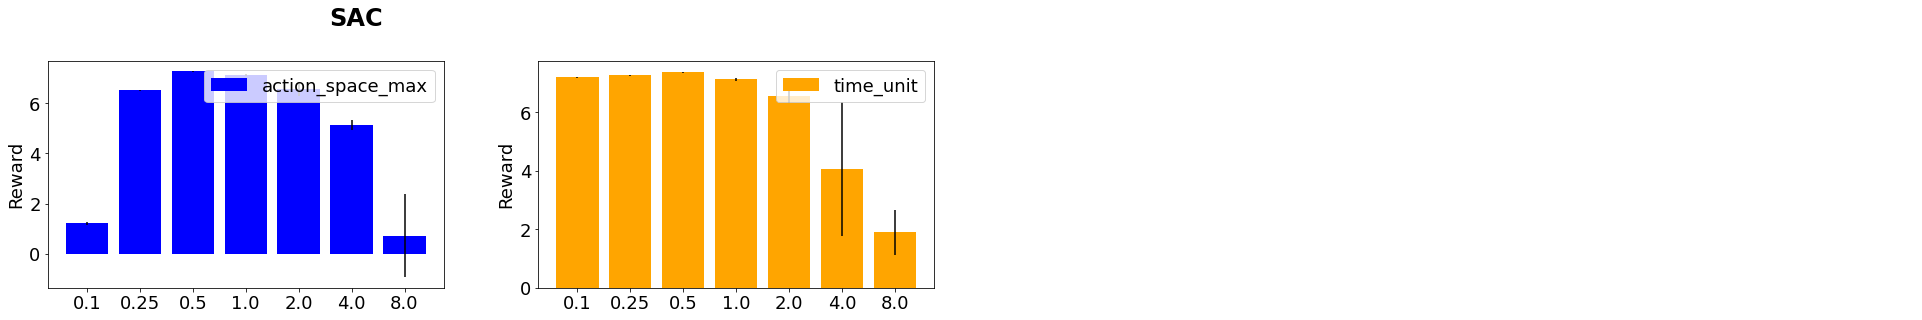

In [4]:
# Plots across 10 runs: Evaluation: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, train=False, plot_type = "agent")

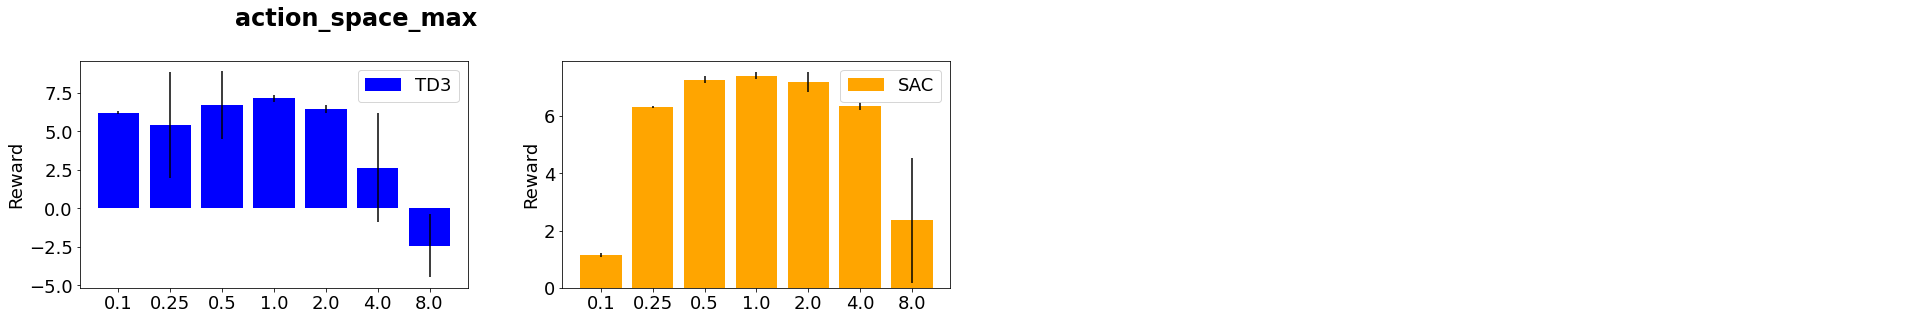

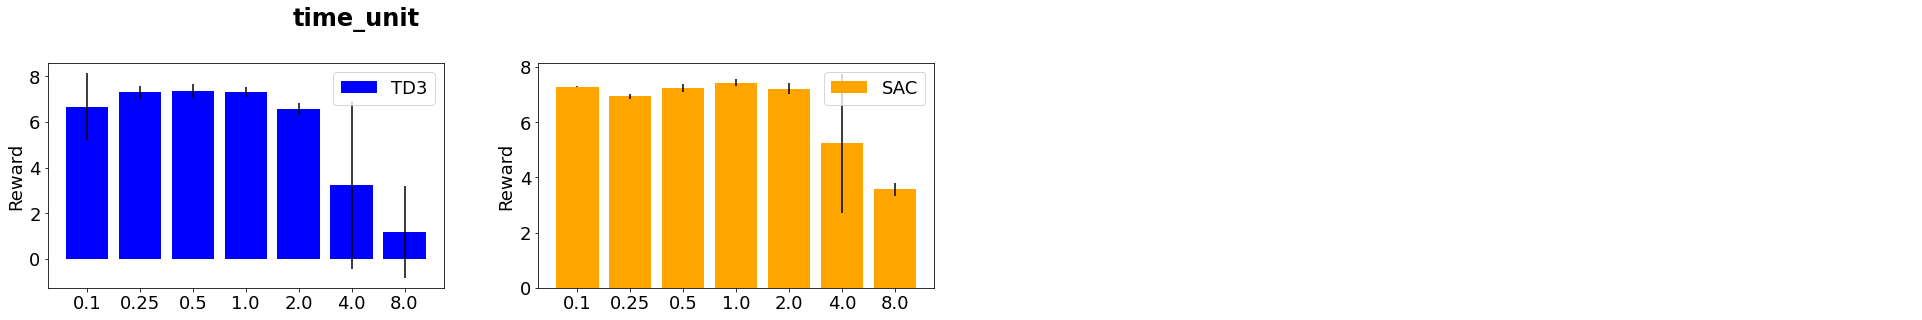

In [5]:
# 1-D: Plots showing reward after 20k timesteps when varying a single meta-feature
# Plots across 10 runs: Training: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, plot_type = "metric")

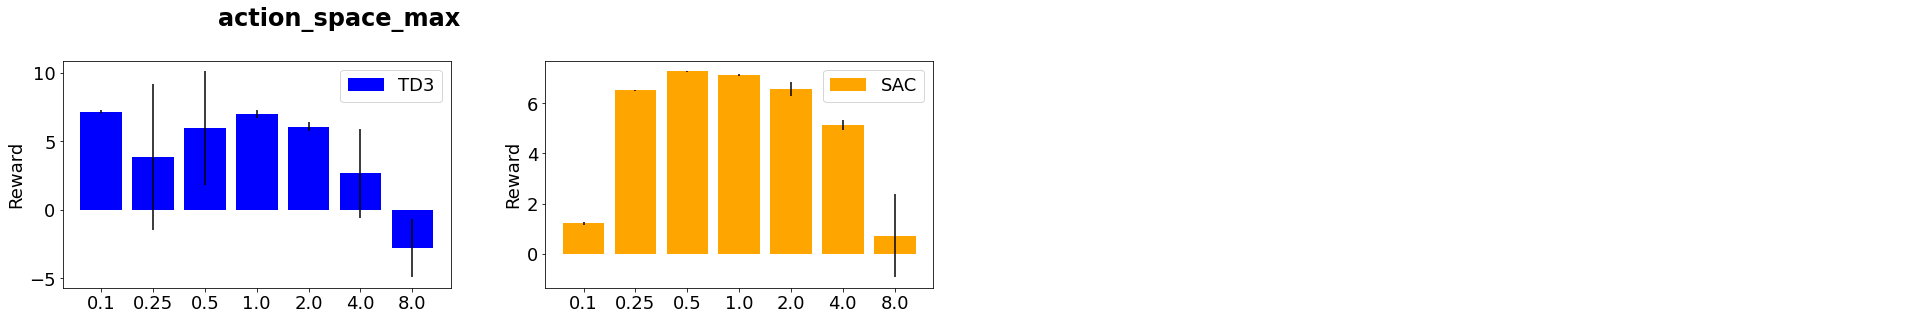

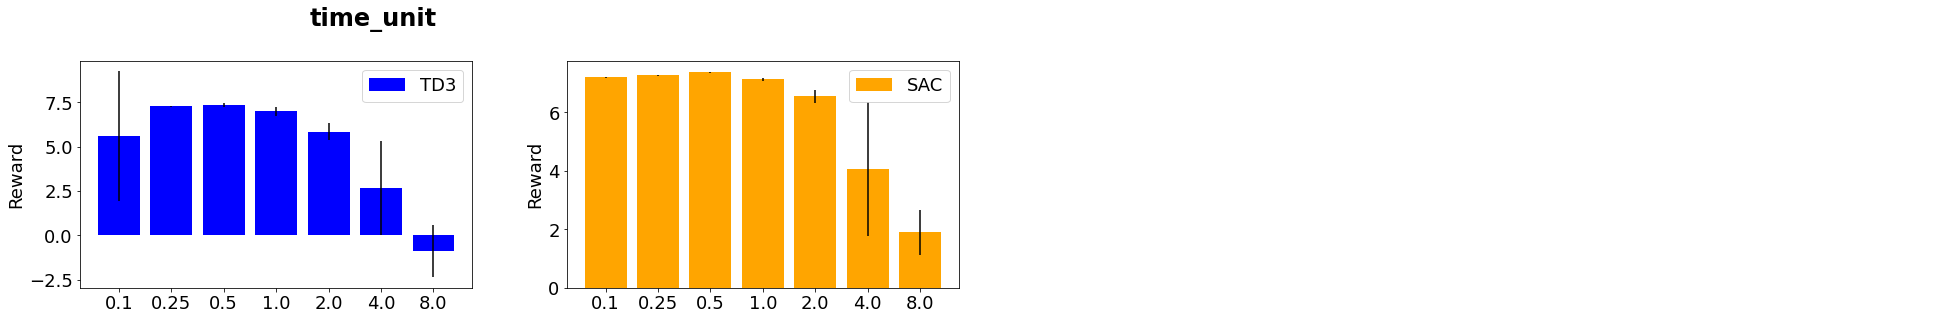

In [6]:
# Plots across 10 runs: Evaluation: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, train=False, plot_type = "metric")

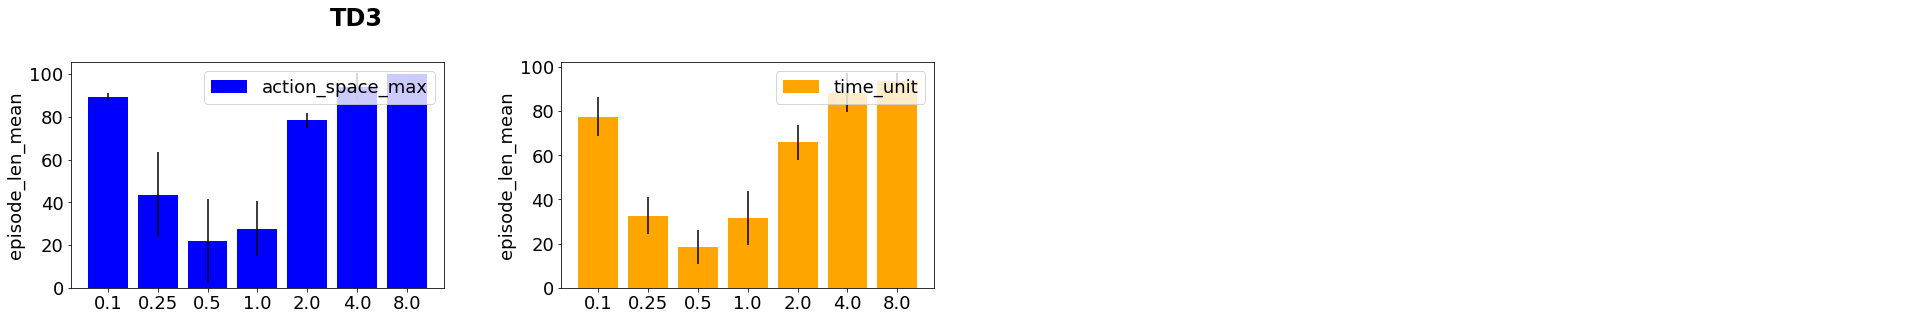

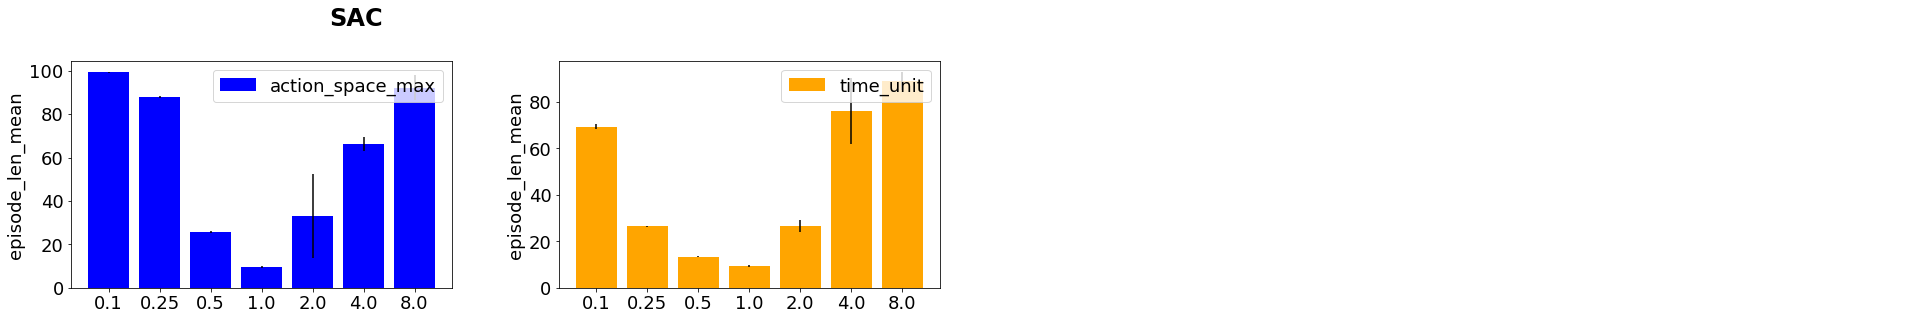

In [7]:
# This and the next cell do the same as the previous 2 cells but plot episode mean lengths instead of episode reward
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, metric_num=-1, plot_type = "agent")

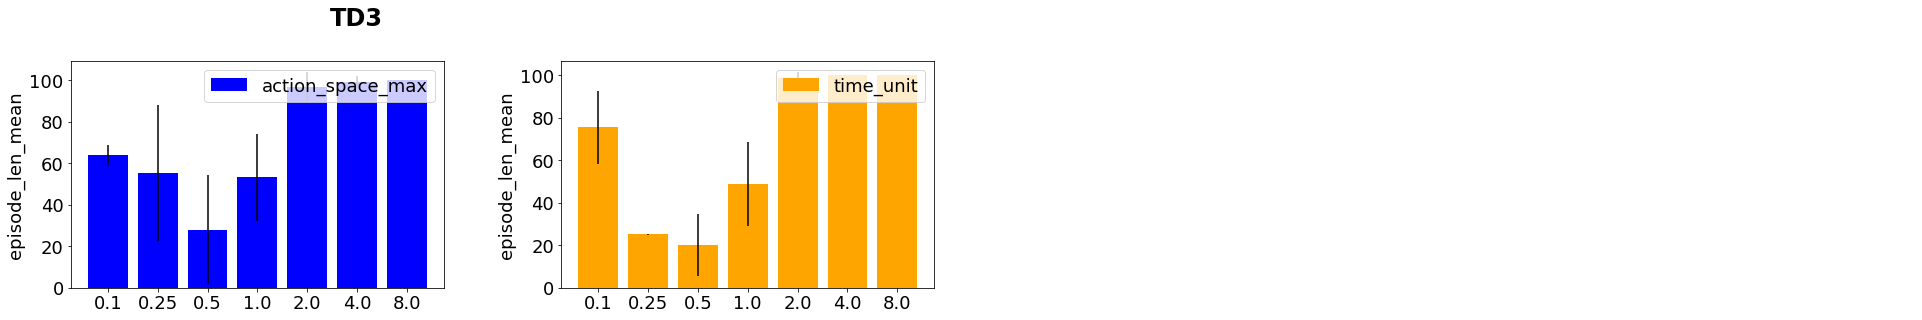

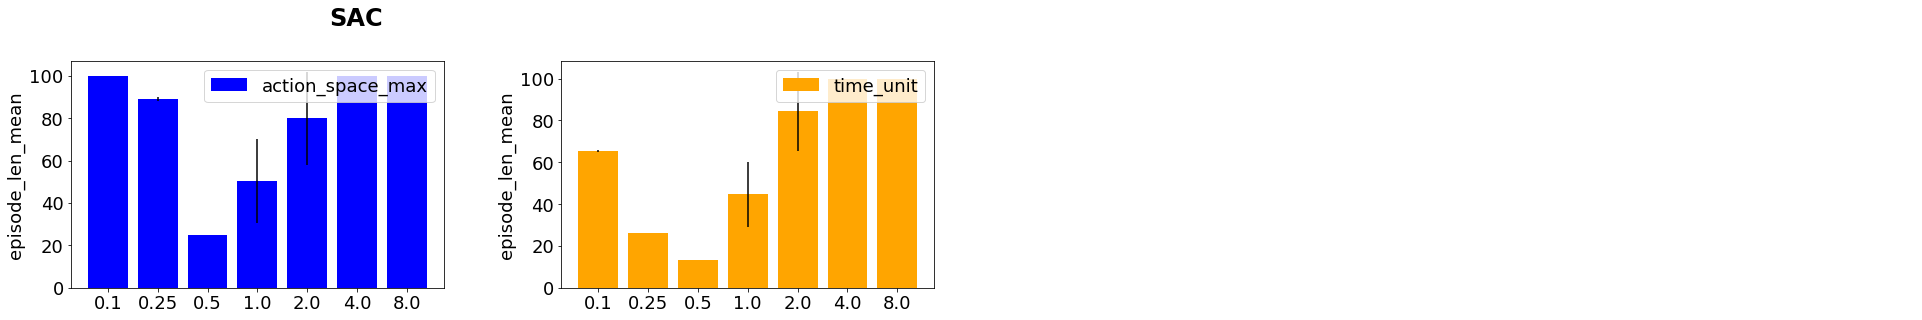

In [8]:
mdpp_analysis.plot_1d_dimensions(list_exp_data, save_fig, train=False, metric_num=-1, plot_type = "agent")

/media/suresh/work/ml_hiwi/mdp-playground/mdp_playground/analysis/analysis.py:506: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(tick_labels[0])


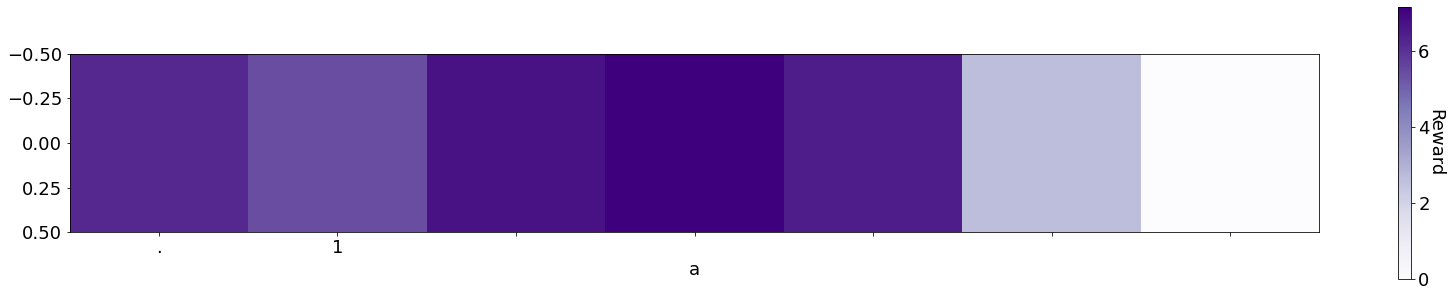

/media/suresh/work/ml_hiwi/mdp-playground/mdp_playground/analysis/analysis.py:526: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(tick_labels[0])


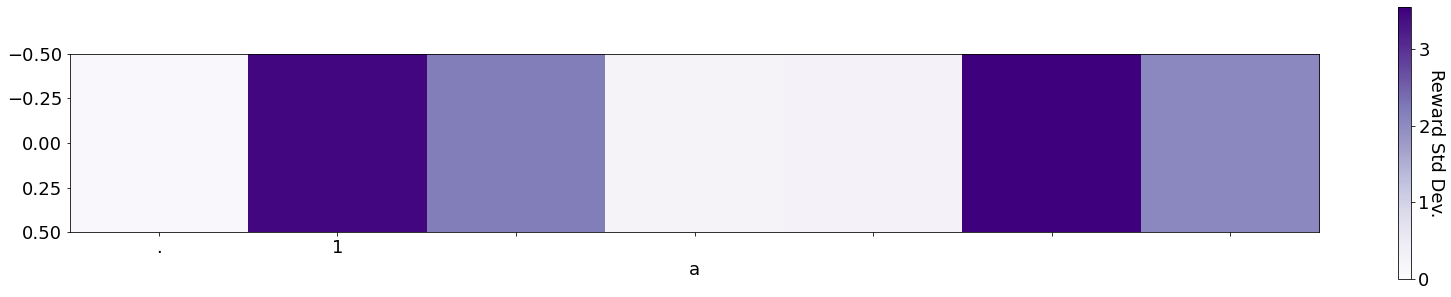

In [9]:
# 2-D heatmap plots across 10 runs: Training runs: with std dev across the runs
# There seems to be a bug with matplotlib - x and y axes tick labels are not correctly set even though we pass them. Please feel free to look into the code and suggest a correction if you find it.
mdpp_analysis.plot_2d_heatmap(list_exp_data, save_fig)

/media/suresh/work/ml_hiwi/mdp-playground/mdp_playground/analysis/analysis.py:506: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(tick_labels[0])


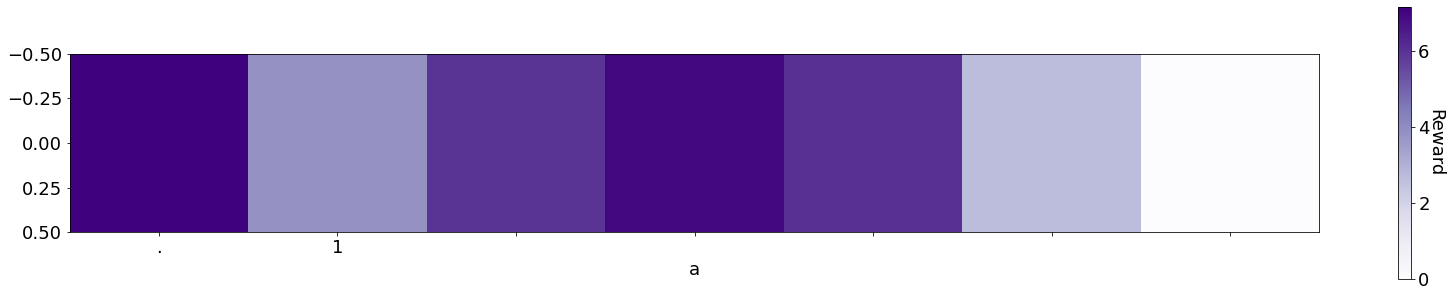

/media/suresh/work/ml_hiwi/mdp-playground/mdp_playground/analysis/analysis.py:526: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(tick_labels[0])


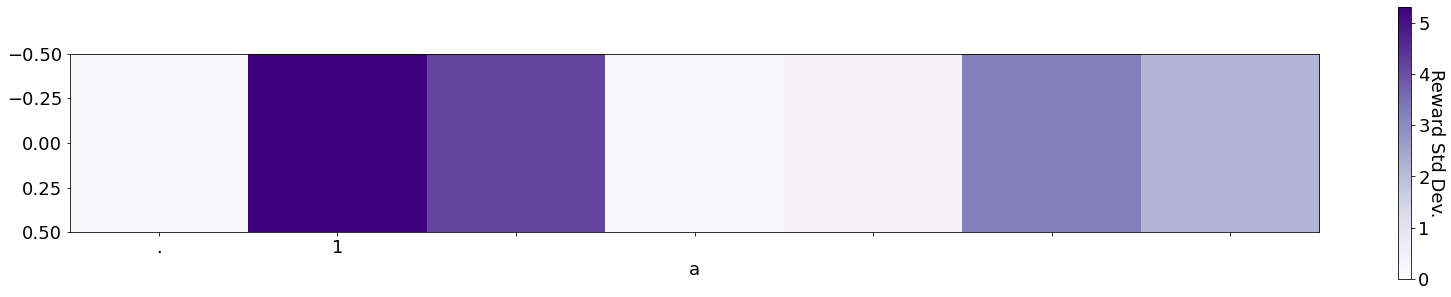

In [10]:
# 2-D heatmap plots across 10 runs: Evaluation runs: with std dev across the runs
mdpp_analysis.plot_2d_heatmap(list_exp_data, save_fig, train=False)

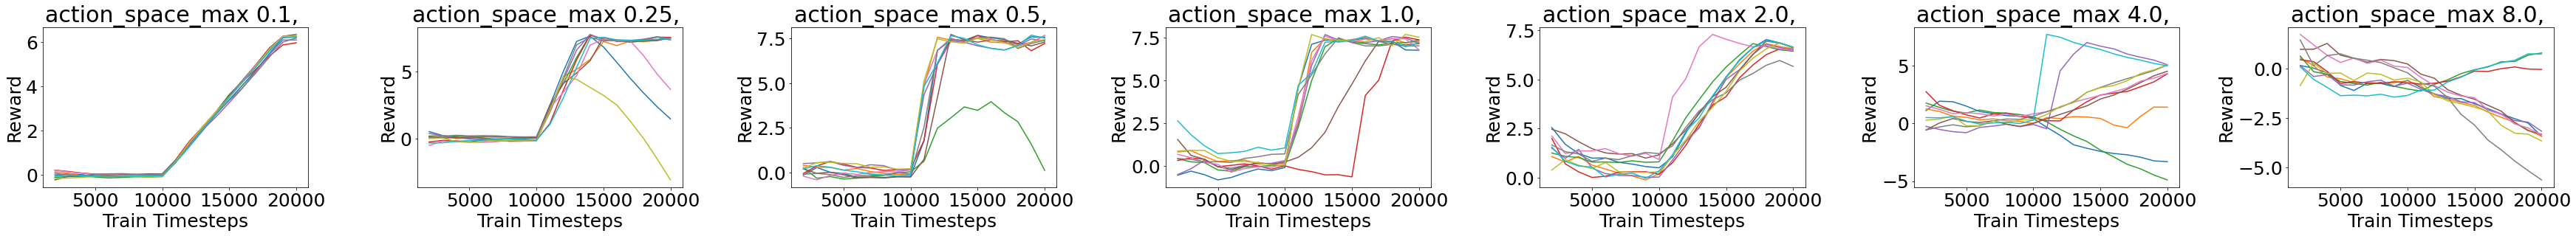

In [11]:
# Plot learning curves: Training: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(list_exp_data, save_fig)

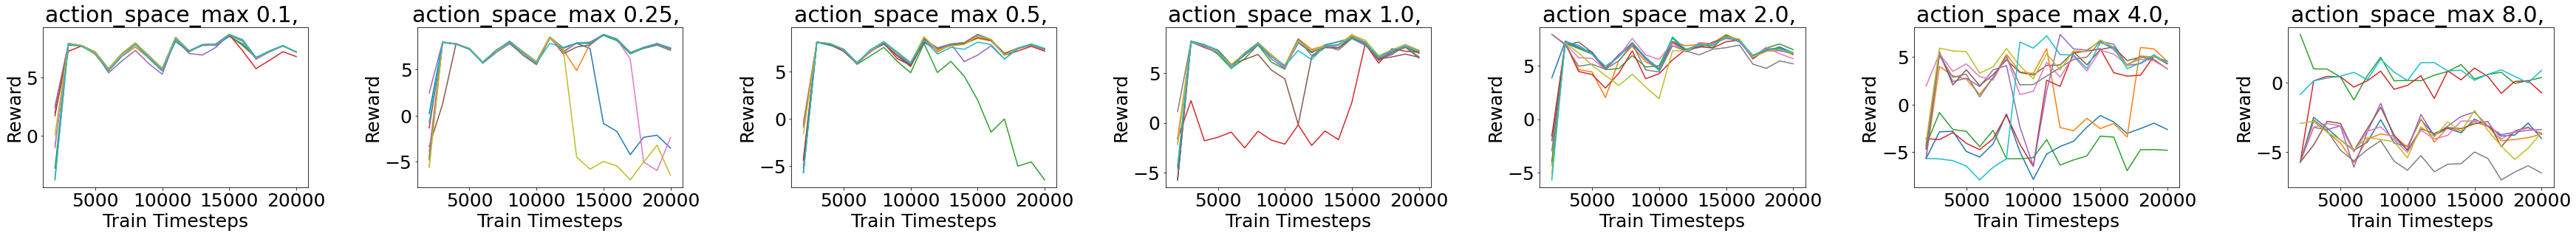

In [12]:
# Plot learning curves: Evaluation: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(list_exp_data, save_fig, train=False)